# BLU04- Learning Notebook - Part 3 of 3 - Time series modelling concepts

With the multi-index, rolling windows and resampling methods we've shown you, there are already a lot of questions about historical data you can answer. But what about predicting the future values for stock markets, electricity demand, pollution levels, etc? To do that, we need to enter into the realm of **forecasting**. In BLU05 you will learn how to do this using classical models, and in BLU06 using ML models. But before that, it's important to understand the fundamental concepts behind time series modelling, which apply both to classical and ML models. This is the focus of this notebook.

In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
import utils

plt.rcParams["figure.figsize"]=(5.6,4.2)

## 1. Time Series Concepts

Time series can be thought of as a (linear or non-linear) composition of 4 components: **trend**, **cyclical**, **seasonal** and **irregular**.

$$Y_t = Trend + Cyclical + Seasonal + Irregular$$

Or

$$Y_t = Trend \cdot Cyclical \cdot Seasonal \cdot Irregular$$

Or another non-linear combination of all four (in BLU05 we will tell you how to know whether the composition should be additive or multiplicative). Each one of the four components is also a time series.  

### 1.1 Trend

The trend is the component of the time series that allows us to see if, in general, the dependent variable we are observing is increasing, without taking into consideration local fluctuations. Usually, people look at the trend to see if the mean value of a series is (monotonically) increasing or decreasing. The trend can be modelled as a linear or non-linear process, even though people prefer to assume it is linear.

In order to understand the concept of trend, let's look at a dataset with [monthly totals of a US airline passengers from 1949 to 1960](https://www.kaggle.com/chirag19/air-passengers).

In [2]:
data = utils.load_airlines_series()
data.head()

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
Name: thousands of passengers, dtype: float64

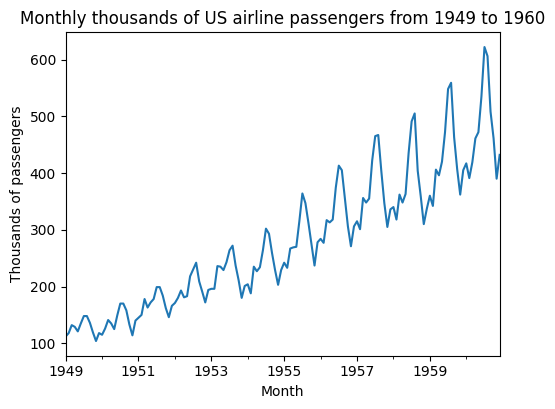

In [3]:
data.plot();
plt.ylabel('Thousands of passengers')
plt.title("Monthly thousands of US airline passengers from 1949 to 1960");

#### 1.1.1 Estimating trend with the linear regression
The first thing you probably notice is that, in general, the *passengers are increasing* even though there are annual peaks. In order to visualize the trend, let's plot a simple linear regression that maps the time and the passenger number.

We make it simple by taking the time out of the equation - we use the row numbers as the X values by resetting the index:

In [4]:
data.reset_index().head(5)

,Month,thousands of passengers
0,1949-01-01,112.0
1,1949-02-01,118.0
2,1949-03-01,132.0
3,1949-04-01,129.0
4,1949-05-01,121.0


Now we set up the model and fit it to X (row numbers) and y (number of passengers). Finally, we make the prediction and replace the index with the original time data.

In [5]:
X = data.reset_index().index.to_numpy().reshape(-1,1)
slr = LinearRegression(fit_intercept=True)
slr.fit(X, data)
linear_trend = pd.Series(slr.predict(X), index=data.index)

Let's see the result:

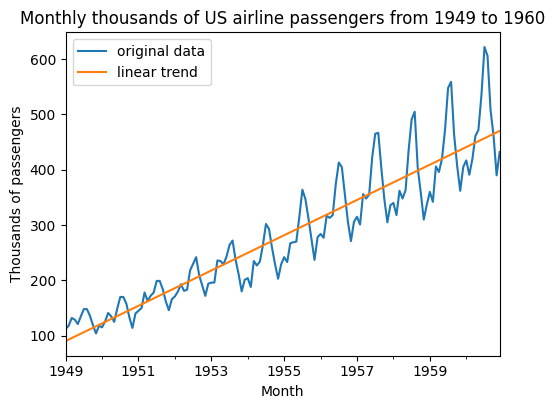

In [6]:
data.plot(label="original data")
linear_trend.plot(label="linear trend")
plt.ylabel('Thousands of passengers')
plt.title("Monthly thousands of US airline passengers from 1949 to 1960")
plt.legend();

Let's also check the R² score of this simple model

In [7]:
slr.score(X, data)

0.853638165603188

Not bad for a really simple model!

#### 1.1.2 Estimating trend with the moving average
Another very common approach to trend estimation is the **moving average**. You already used this method in a previous notebook. Indeed, a moving average can be used for smoothing a signal but also for estimating its trend. With this method, you need to set the window size. Let's start with a window size of 6 (months).

In [8]:
moving_avg_6_months = data.rolling(6).mean()
moving_avg_6_months.head(10)

Month
1949-01-01           NaN
1949-02-01           NaN
1949-03-01           NaN
1949-04-01           NaN
1949-05-01           NaN
1949-06-01    124.500000
1949-07-01    130.500000
1949-08-01    135.500000
1949-09-01    136.166667
1949-10-01    134.500000
Name: thousands of passengers, dtype: float64

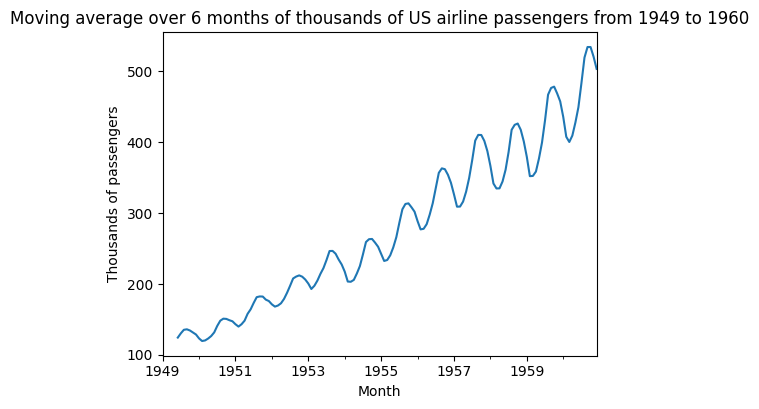

In [9]:
moving_avg_6_months.plot();
plt.ylabel('Thousands of passengers')
plt.title("Moving average over 6 months of thousands of US airline passengers from 1949 to 1960");

As you noticed, there are 5 NaNs in the moving average series. That is because the first 5 elements do not have enough data for a window of 6. We can "fix" this by setting `min_periods` to 0.

In [10]:
moving_avg_6_months_ = data.rolling(6, min_periods=0).mean()
moving_avg_6_months_.head(10)

Month
1949-01-01    112.000000
1949-02-01    115.000000
1949-03-01    120.666667
1949-04-01    122.750000
1949-05-01    122.400000
1949-06-01    124.500000
1949-07-01    130.500000
1949-08-01    135.500000
1949-09-01    136.166667
1949-10-01    134.500000
Name: thousands of passengers, dtype: float64

Setting `min_periods` to something smaller than 6 will make pandas copy the values from the original series into the moving average series. To confirm this, let's look at the original series.

In [11]:
data.head(10)

Month
1949-01-01    112.0
1949-02-01    118.0
1949-03-01    132.0
1949-04-01    129.0
1949-05-01    121.0
1949-06-01    135.0
1949-07-01    148.0
1949-08-01    148.0
1949-09-01    136.0
1949-10-01    119.0
Name: thousands of passengers, dtype: float64

Let's see how it looks in a plot.

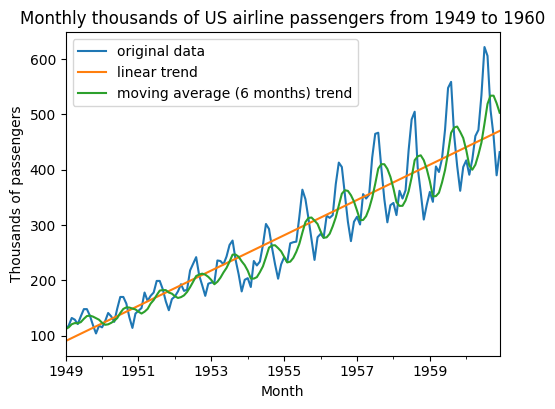

In [12]:
data.plot(label="original data")
linear_trend.plot(label="linear trend")
moving_avg_6_months_.plot(label="moving average (6 months) trend")
plt.ylabel('Thousands of passengers')
plt.title("Monthly thousands of US airline passengers from 1949 to 1960")
plt.legend();

We should note that setting `min_periods` to 0 is fine for visualization purposes BUT once you start using trend estimation to prepare your time series for modelling, using `min_periods=0` is not ok at all.

What if we used a larger window? Like 12 months.

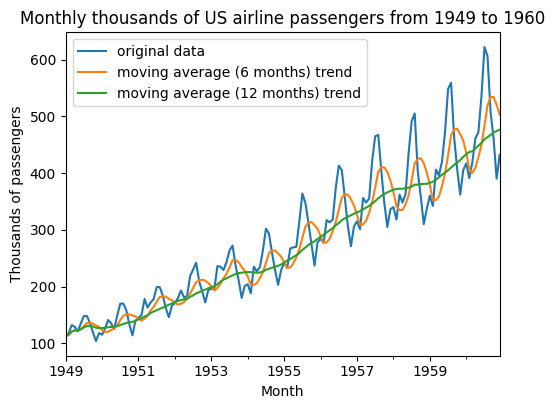

In [13]:
moving_avg_12_months_ = data.rolling(12, min_periods=0).mean()

data.plot(label="original data")
moving_avg_6_months_.plot(label="moving average (6 months) trend")
moving_avg_12_months_.plot(label="moving average (12 months) trend")
plt.ylabel('Thousands of passengers')
plt.title("Monthly thousands of US airline passengers from 1949 to 1960")
plt.legend();

And what about 24 months?

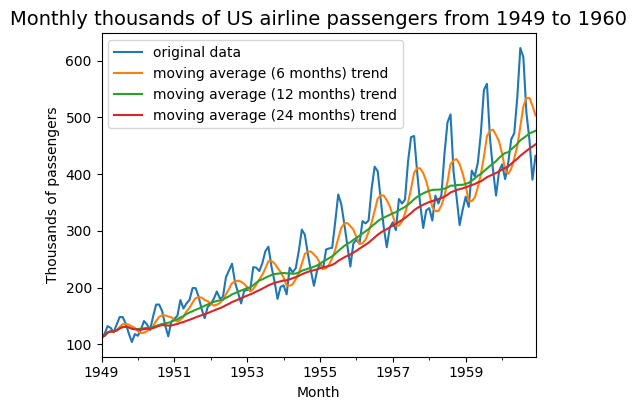

In [14]:
moving_avg_24_months_ = data.rolling(24, min_periods=0).mean()

data.plot(label="original data")
moving_avg_6_months_.plot(label="moving average (6 months) trend")
moving_avg_12_months_.plot(label="moving average (12 months) trend")
moving_avg_24_months_.plot(label="moving average (24 months) trend")
plt.ylabel('Thousands of passengers')
plt.title("Monthly thousands of US airline passengers from 1949 to 1960", size=14)
plt.legend();

Every time we increase the window size for the moving average, we get a smoother and more stable time series. But...what is a good window size? The answer is: it depends on your business expectations and the time series. 12 months or a bit more seems like a good choice in this case, since the peaks are about this length. 

Also, a final note about trend estimation: several existing techniques for trend estimation include both the trend and cyclical components.

### 1.2 Cyclical

The cyclical component corresponds to repeating patterns that occur in non-regular time intervals. For example, the performance of the world economy after the 1950s experienced 4 global recessions, in 1975, 1982, 1991, and 2009. Our airline passengers data does not have a cyclical component.

### 1.3 Seasonal

Unlike the cyclical component, the seasonal component changes at a fixed rate. For example, the bookings in hotels in certain cities have well known maxima (Autumn) and minima (Summer). 

Our airline passenger dataset also has clear seasonality. We can see minima and maxima with a regular pattern every year. 

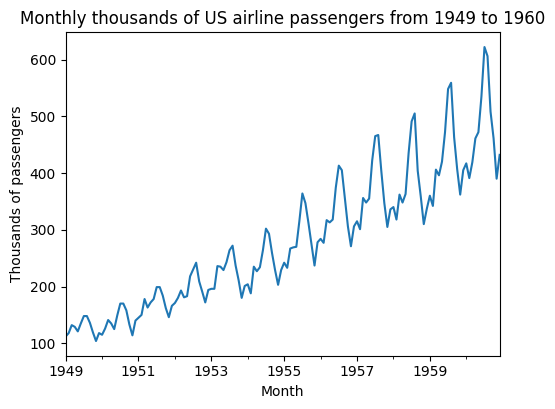

In [15]:
data.plot()
plt.ylabel('Thousands of passengers')
plt.title("Monthly thousands of US airline passengers from 1949 to 1960");

To highlight the yearly pattern, let's plot the time series for each year.

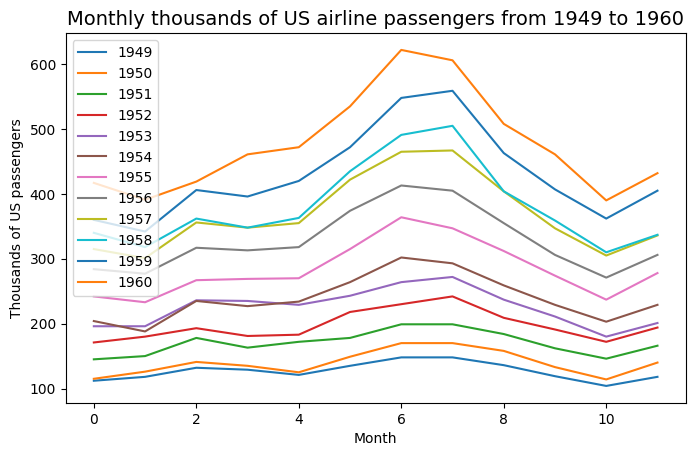

In [16]:
utils.plot_seasonality_for_airlines()

Around June-July, we get the peak and around October, we get the period with fewest passengers. 

But how can we convey seasonality to a model? Well, we can start by looking at **lags** scatter: draw a scatter plot between y(t) and y(t-lag). In other words, what is the relationship between the number of flights in a given month and lag months earlier?

#### 1.3.1 Missing data... again?

Before the next step, we need to make sure that our dataset doesn't have missing dates. Usually we would do:

In [17]:
data.isnull().sum()

0

But actually this only means that there are no NaNs in the dataset. What if our dataset simply doesn't contain the row for a certain month? We wouldn't detect it by using `isnull`. To solve this we can use the `resample` method you learned in the last notebook. Since our data has a monthly frequency if we resample it monthly, any missing months will be created. The `asfreq` method makes it so that any row created by the resample will contain a NaN.

In [18]:
data = data.resample('MS').asfreq()
data.isnull().sum()

0

#### 1.3.2 Correlation as a proxy for seasonality
Ok, our dataset has all consecutive months without anything missing in between, let's proceed!

We can now use pandas [shift](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.shift.html#pandas.Series.shift) function, which shifts the values without realigning the data (basically a lag on the values). In the example below we can see that a negative shift of -1 means that we're looking at y(t+1). Note that the last value will be NaN, this is not problematic for visualization but maybe for modelling.

In [19]:
data = data.to_frame()
data['lag_1'] = data['thousands of passengers'].shift(-1)
data['lag_2'] = data['thousands of passengers'].shift(-2)
data['lag_3'] = data['thousands of passengers'].shift(-3)
data['lag_8'] = data['thousands of passengers'].shift(-8)
data['lag_12'] = data['thousands of passengers'].shift(-12)

In [20]:
data.head()

,thousands of passengers,lag_1,lag_2,lag_3,lag_8,lag_12
Month,,,,,,
1949-01-01,112.0,118.0,132.0,129.0,136.0,115.0
1949-02-01,118.0,132.0,129.0,121.0,119.0,126.0
1949-03-01,132.0,129.0,121.0,135.0,104.0,141.0
1949-04-01,129.0,121.0,135.0,148.0,118.0,135.0
1949-05-01,121.0,135.0,148.0,148.0,115.0,125.0


We can now test different shifts, plot y(t+lag) against y(t), and see the relationship between them. For example, we can see that there seems to be some correlation between y(t+1) and y(t). It makes sense that the number of passengers the month before has some relation with the number of passengers in the present month.

It's also interesting to note that this correlation seems to decrease as the lag increases, for lags 2, 3 and 8 (note how the plots become wider)

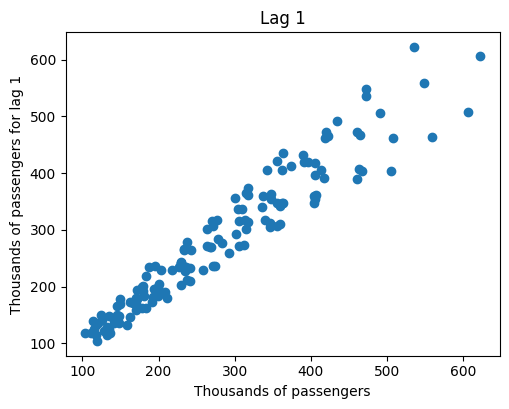

In [21]:
plt.scatter(data['thousands of passengers'], data.lag_1)
plt.ylabel('Thousands of passengers for lag 1')
plt.xlabel('Thousands of passengers')
plt.title("Lag 1");

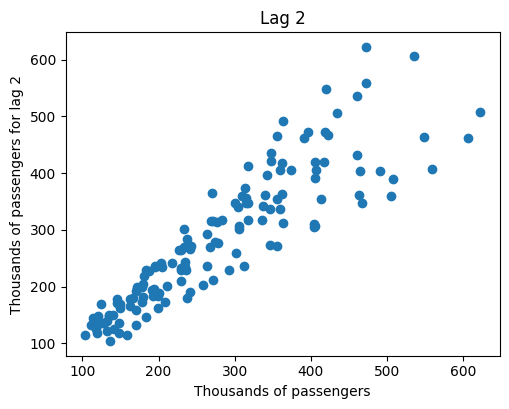

In [22]:
plt.scatter(data['thousands of passengers'], data.lag_2)
plt.ylabel('Thousands of passengers for lag 2')
plt.xlabel('Thousands of passengers')
plt.title("Lag 2");

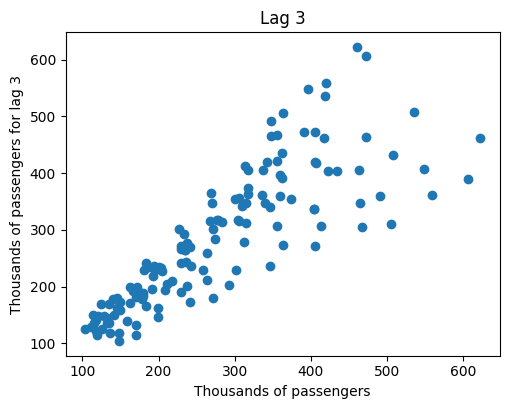

In [23]:
plt.scatter(data['thousands of passengers'], data.lag_3)
plt.ylabel('Thousands of passengers for lag 3')
plt.xlabel('Thousands of passengers')
plt.title("Lag 3");

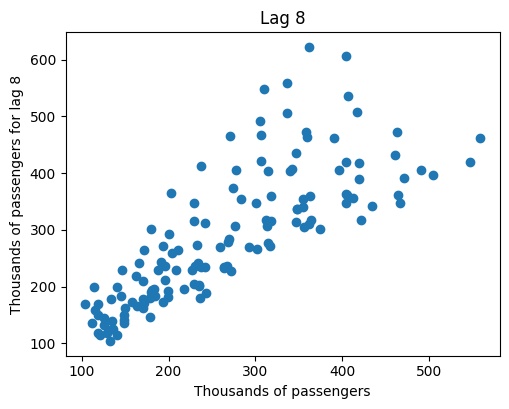

In [24]:
plt.scatter(data['thousands of passengers'], data.lag_8)
plt.ylabel('Thousands of passengers for lag 8')
plt.xlabel('Thousands of passengers')
plt.title("Lag 8");

But now, for lag = 12 the correlation clearly increases, being even higher than for lag = 1. This seems to indicate that there is a strong yearly seasonality, corroborating what we saw in the previous plots.

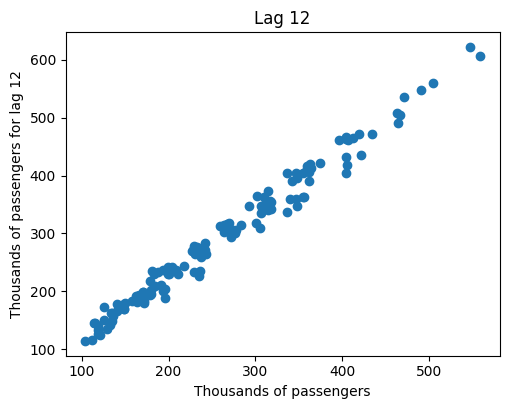

In [25]:
plt.scatter(data['thousands of passengers'], data.lag_12)
plt.ylabel('Thousands of passengers for lag 12')
plt.xlabel('Thousands of passengers')
plt.title("Lag 12");

We can also look at the Pearson correlation using pandas `corr()` method, which confirms the suspicions from the correlation plots - there seems to be a strong yearly seasonality.

In [26]:
data.corr()['thousands of passengers']

thousands of passengers    1.000000
lag_1                      0.960195
lag_2                      0.895675
lag_3                      0.837395
lag_8                      0.792215
lag_12                     0.990527
Name: thousands of passengers, dtype: float64

**Note:** If our dataset had missing months, the most appropriate way to calculate correlation would be to resample with asfreq, so that the missing months are indicated as NaNs and end up being ignored in the correlation. If you don't resample it first, the correlation will be wrong, because the shifts will not have the meaning they should have due to the missing data.

This analysis is hinting at a very important concept: auto-correlation. Indeed, auto-correlation is very important to convey seasonality information to a model, and you will learn more about it in BLU05.

### 1.4 Irregular

After accounting for all the previous components, the remaining component, called *irregular* or *residual*, won't have any pattern. This part of the time series is considered noise. You might be thinking that this component is useless. But, in fact, several modelling techniques analyze this component in order to check if a better model can be created. If the residuals are not pure noise, we get still improve our model.

## 2. Example

After introducing all 4 components, let's look into more examples

![four example time series](media/ts-examples.png "")

The upper left time series shows both a seasonal component for each year and a strong cyclical component that takes 6-10 years (imagine an ark connecting 1975 to 1981 and another one connecting 1981 and 1991) but no apparent trend.

In the upper right corner, we have a strong negative trend but no visible seasonal nor cyclical behavior. This might be due to how small the time series was. 

Thh series in the lower left corner shows both a strong (positive) trend and seasonality but no cyclical component.

Finally, the time series in the lower right corner looks like pure noise. No clear pattern.

You might be asking "Are there any tools to help me identify all 4 components? After identifying them, what can I do with them?". The answers to these questions will be given in the next BLU ;)

## 3. Summary
* `shift` - shift allows you to shift the data without realigning the index of the time series 

**A few examples:**

* Data of the previous time period : data['thousands of passengers'].shift(+1)
* Data of the next time period : data['thousands of passengers'].shift(-1)